In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')  

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [42]:
file_path = 'WildBlueberryPollinationSimulationData.csv'
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())  # Should be zero

Dataset Shape: (777, 18)

First 5 Rows:
    Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0     0       37.5      0.75     0.25     0.25   0.25              86.0   
1     1       37.5      0.75     0.25     0.25   0.25              86.0   
2     2       37.5      0.75     0.25     0.25   0.25              94.6   
3     3       37.5      0.75     0.25     0.25   0.25              94.6   
4     4       37.5      0.75     0.25     0.25   0.25              86.0   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              52.0                  71.9              62.0              30.0   
1              52.0                  71.9              62.0              30.0   
2              57.2                  79.0              68.2              33.0   
3              57.2                  79.0              68.2              33.0   
4              52.0                  71.9              62.0              30.0   

   AverageOfLowerTRan


Summary Statistics:
              Row#   clonesize    honeybee     bumbles     andrena       osmia  \
count  777.000000  777.000000  777.000000  777.000000  777.000000  777.000000   
mean   388.000000   18.767696    0.417133    0.282389    0.468817    0.562062   
std    224.444871    6.999063    0.978904    0.066343    0.161052    0.169119   
min      0.000000   10.000000    0.000000    0.000000    0.000000    0.000000   
25%    194.000000   12.500000    0.250000    0.250000    0.380000    0.500000   
50%    388.000000   12.500000    0.250000    0.250000    0.500000    0.630000   
75%    582.000000   25.000000    0.500000    0.380000    0.630000    0.750000   
max    776.000000   40.000000   18.430000    0.585000    0.750000    0.750000   

       MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange  \
count        777.000000        777.000000            777.000000   
mean          82.277091         49.700515             68.723037   
std            9.193745          5.595769      

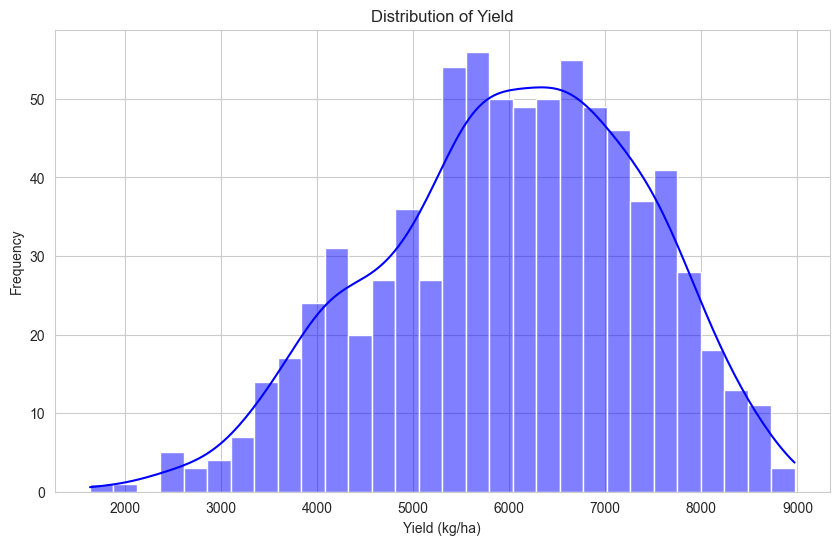

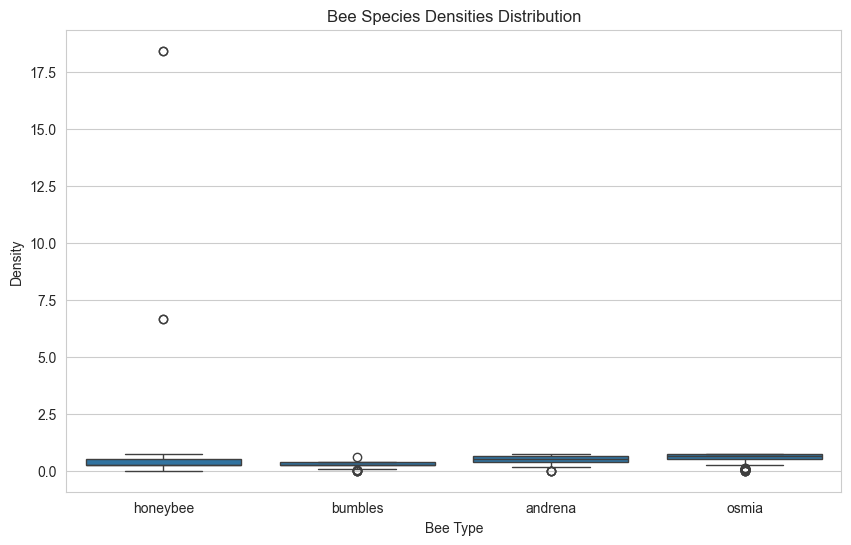

In [43]:
print("\nSummary Statistics:\n", df.describe())

# Distribution of target variable 'yield'
plt.figure()
sns.histplot(df['yield'], kde=True, bins=30, color='blue')
plt.title('Distribution of Yield')
plt.xlabel('Yield (kg/ha)')
plt.ylabel('Frequency')
plt.show()

# Boxplots for bee species densities
bee_features = ['honeybee', 'bumbles', 'andrena', 'osmia']
df_bees = df[bee_features].melt(var_name='Bee Type', value_name='Density')
plt.figure()
sns.boxplot(x='Bee Type', y='Density', data=df_bees)
plt.title('Bee Species Densities Distribution')
plt.show()


Correlations with Yield (Top 10):
 yield               1.000000
fruitset            0.984081
seeds               0.961249
fruitmass           0.930365
osmia               0.380892
bumbles             0.309407
andrena             0.140277
Row#               -0.024942
honeybee           -0.044250
MinOfUpperTRange   -0.175883
Name: yield, dtype: float64


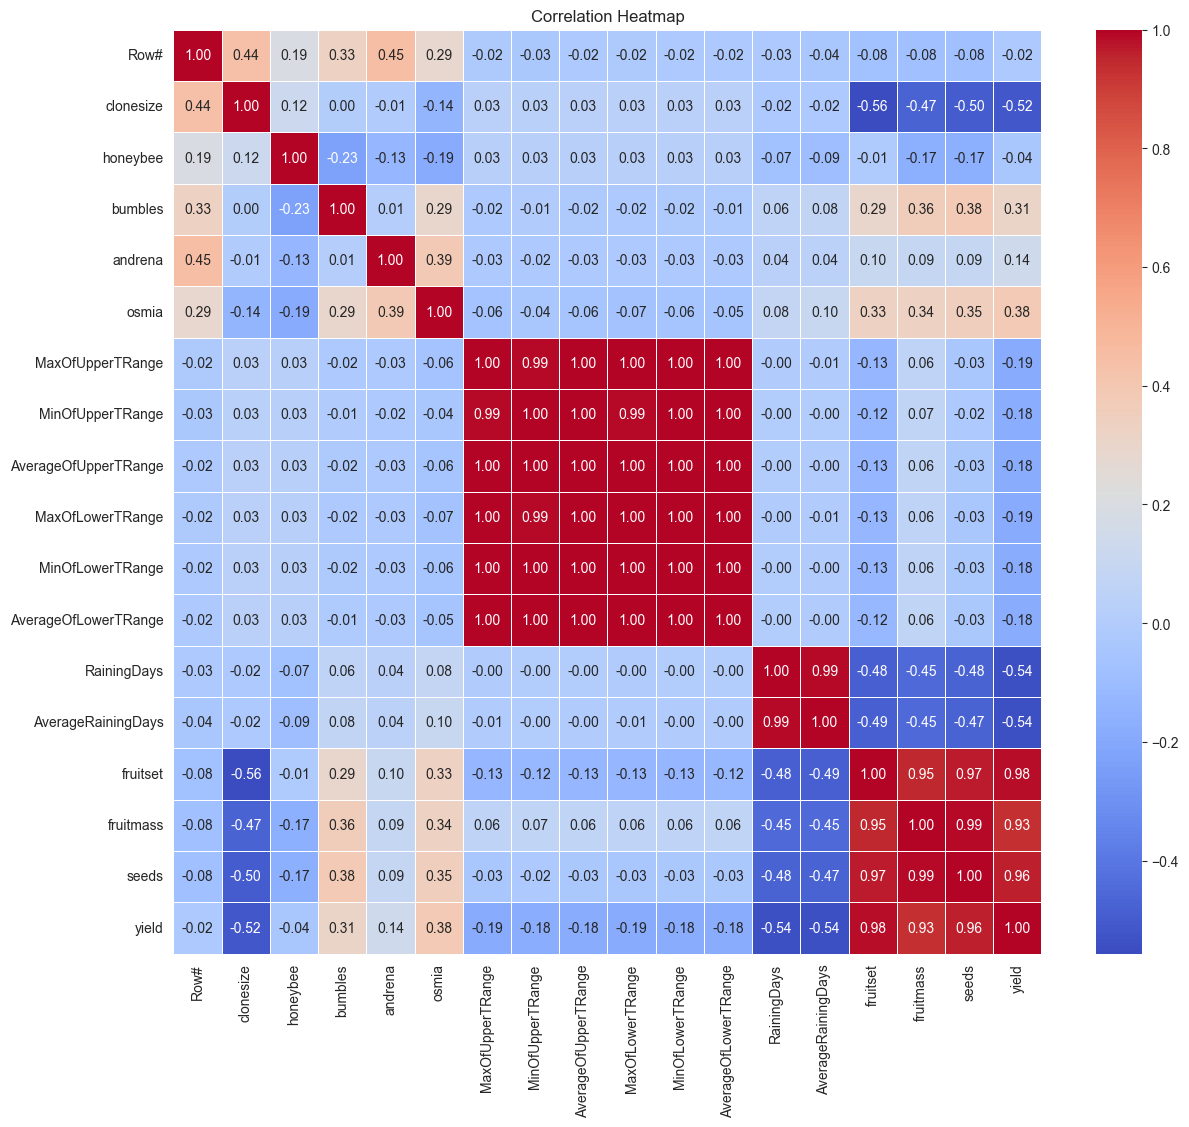

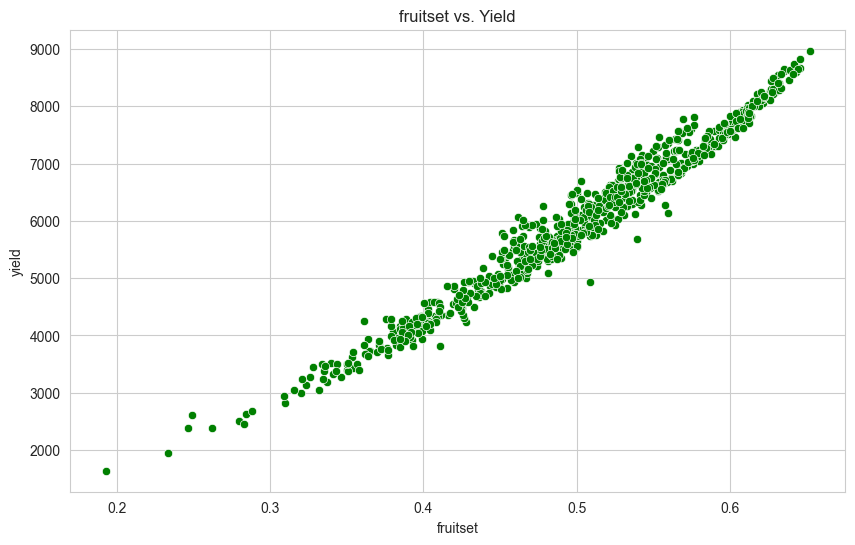

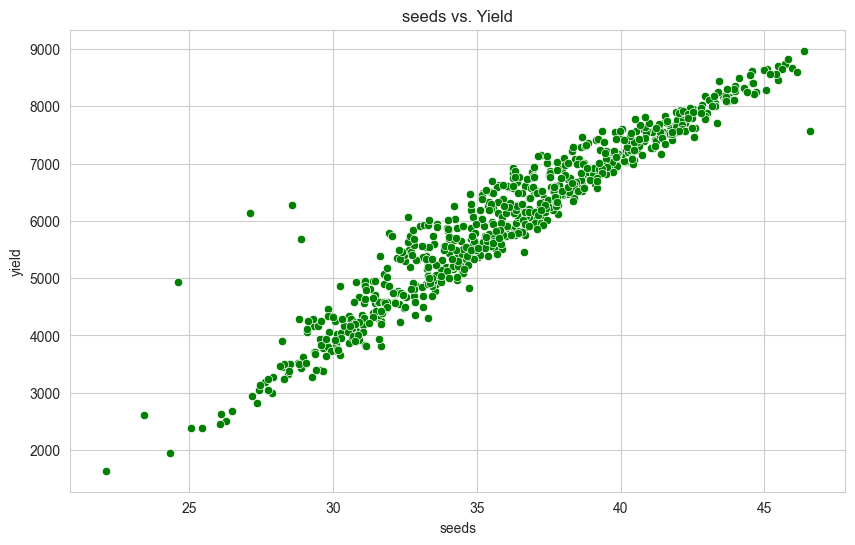

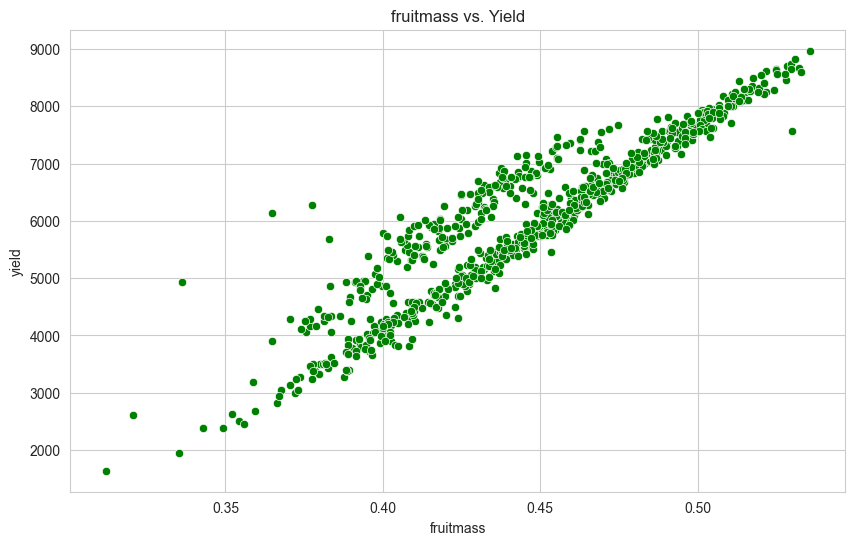

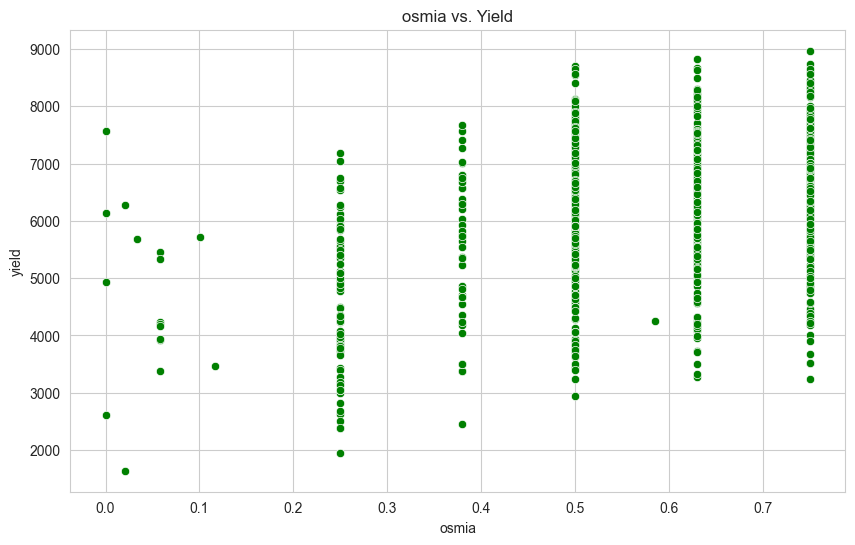

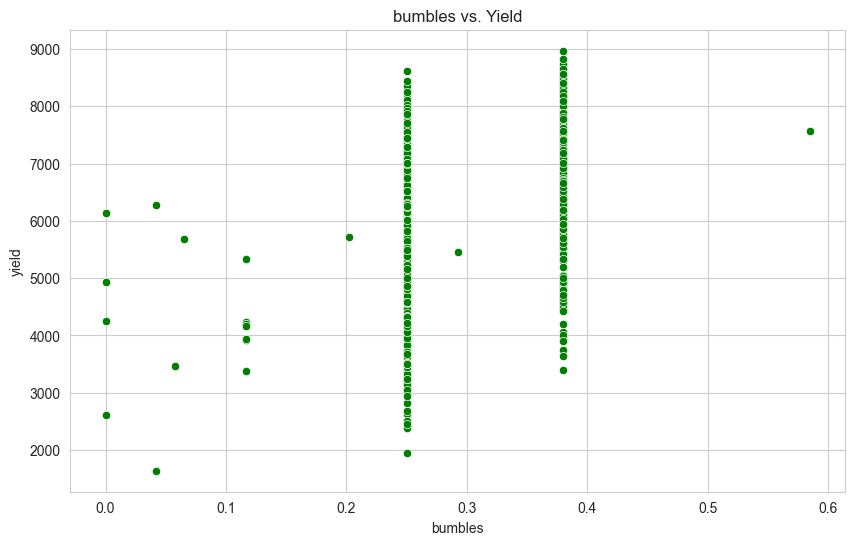

In [44]:
# Correlation matrix (focus on correlations with 'yield')
corr_matrix = df.corr()
print("\nCorrelations with Yield (Top 10):\n", corr_matrix['yield'].sort_values(ascending=False).head(10))

# Heatmap of correlations
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots for key features vs. yield
key_features = ['fruitset', 'seeds', 'fruitmass', 'osmia', 'bumbles']
for feature in key_features:
    plt.figure()
    sns.scatterplot(x=df[feature], y=df['yield'], color='green')
    plt.title(f'{feature} vs. Yield')
    plt.show()


# 4. Data Preprocessing

In [45]:
selected_features = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'RainingDays']
X = df[selected_features]
y = df['yield']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrain Shape:", X_train.shape, "Test Shape:", X_test.shape)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train Shape: (621, 7) Test Shape: (156, 7)


# 5. Model Training and Hyperparameter Tuning

In [46]:

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rrmse = (rmse / np.mean(y_test)) * 100
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}, RRMSE: {rrmse:.3f}%")
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'RRMSE': rrmse}, y_pred

### 5.1 Multiple Linear Regression (MLR)

In [47]:
lr_model = LinearRegression()
lr_metrics, lr_pred = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "MLR")


MLR Performance:
RMSE: 579.286, MAE: 498.148, R²: 0.827, RRMSE: 9.870%


### 5.2 Boosted Decision Tree (AdaBoost)

In [48]:

ada = AdaBoostRegressor(random_state=42)
ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
ada_grid = GridSearchCV(ada, ada_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ada_grid.fit(X_train, y_train)
print("\nBest AdaBoost Params:", ada_grid.best_params_)
ada_metrics, ada_pred = evaluate_model(ada_grid.best_estimator_, X_train, X_test, y_train, y_test, "AdaBoost")


Best AdaBoost Params: {'learning_rate': 1.0, 'n_estimators': 200}

AdaBoost Performance:
RMSE: 577.143, MAE: 420.387, R²: 0.829, RRMSE: 9.834%


### 5.3 Random Forest (RF)

In [49]:

rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("\nBest RF Params:", rf_grid.best_params_)
rf_metrics, rf_pred = evaluate_model(rf_grid.best_estimator_, X_train, X_test, y_train, y_test, "Random Forest")


Best RF Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Performance:
RMSE: 439.808, MAE: 257.261, R²: 0.900, RRMSE: 7.494%


In [50]:
# 5.4 XGBoost
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6], 'subsample': [0.8, 1.0]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("\nBest XGBoost Params:", xgb_grid.best_params_)
xgb_metrics, xgb_pred = evaluate_model(xgb_grid.best_estimator_, X_train, X_test, y_train, y_test, "XGBoost")


Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

XGBoost Performance:
RMSE: 339.679, MAE: 199.879, R²: 0.941, RRMSE: 5.788%


### 5.5 Neural Network (MLP) with PyTorch

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to tensors
X_train_t = torch.tensor(X_train_scaled.astype(np.float32))
y_train_t = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Simple MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.fc(x)

mlp_model = MLP(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

# Train loop
for epoch in range(100):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Evaluate
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled.astype(np.float32))
    y_pred_t = mlp_model(X_test_t).numpy().flatten()
    nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_t))
    print(f"Neural Network RMSE: {nn_rmse:.3f} kg/ha")

# 6. Model Comparison


Model Comparison:
            Model        RMSE         MAE        R²  RRMSE (%)
3        XGBoost  339.679498  199.879414  0.940636   5.787730
2  Random Forest  439.807904  257.261127  0.900479   7.493798
1       AdaBoost  577.142597  420.386625  0.828623   9.833815
0            MLR  579.286160  498.147804  0.827347   9.870339


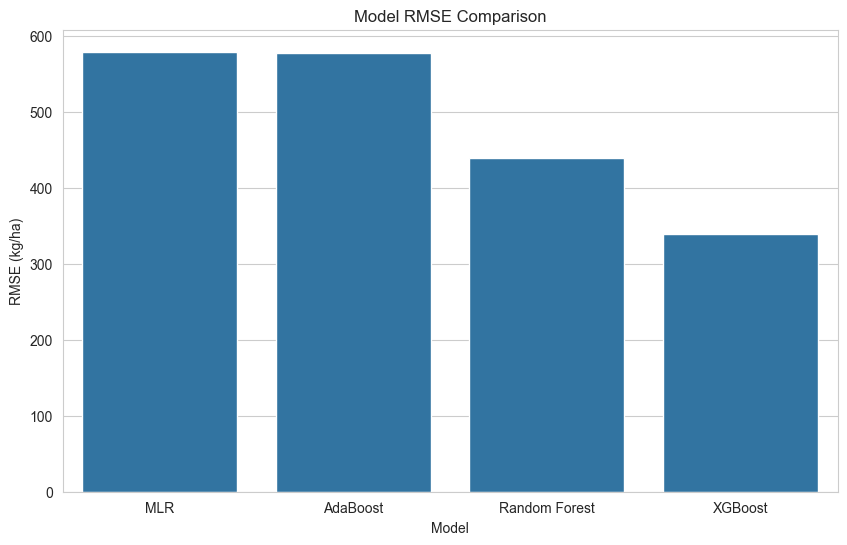

In [51]:
metrics_df = pd.DataFrame({
    'Model': ['MLR', 'AdaBoost', 'Random Forest', 'XGBoost'],
    'RMSE': [lr_metrics['RMSE'], ada_metrics['RMSE'], rf_metrics['RMSE'], xgb_metrics['RMSE']],
    'MAE': [lr_metrics['MAE'], ada_metrics['MAE'], rf_metrics['MAE'], xgb_metrics['MAE']],
    'R²': [lr_metrics['R2'], ada_metrics['R2'], rf_metrics['R2'], xgb_metrics['R2']],
    'RRMSE (%)': [lr_metrics['RRMSE'], ada_metrics['RRMSE'], rf_metrics['RRMSE'], xgb_metrics['RRMSE']]
})
print("\nModel Comparison:\n", metrics_df.sort_values('RMSE'))

# Bar plot for RMSE comparison
plt.figure()
sns.barplot(x='Model', y='RMSE', data=metrics_df)
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE (kg/ha)')
plt.show()


# 7. Feature Importance (Using Best Model: XGBoost)



Feature Importance:
             Feature  Importance
0         clonesize    0.363766
6       RainingDays    0.257813
4             osmia    0.128468
5  MaxOfUpperTRange    0.114910
2           bumbles    0.088192
1          honeybee    0.037421
3           andrena    0.009429


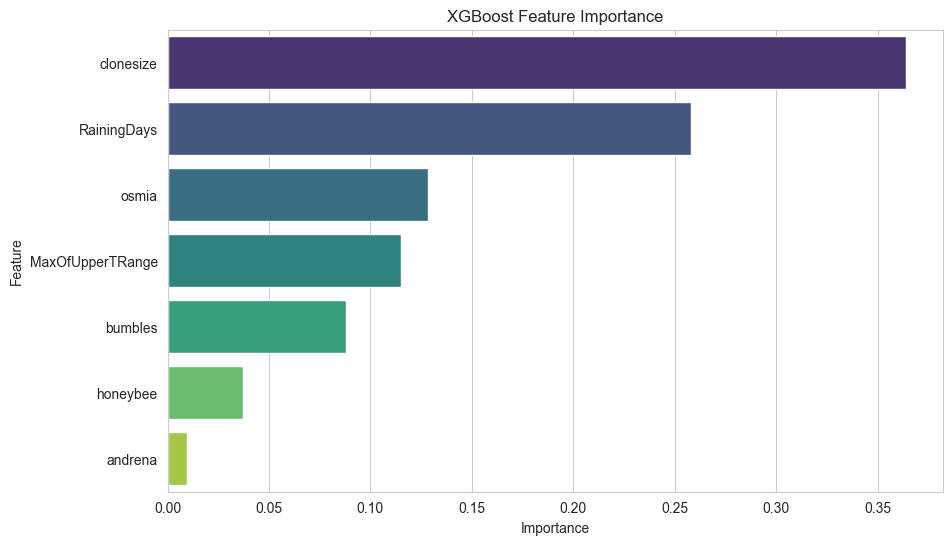

In [52]:
best_model = xgb_grid.best_estimator_
importances = best_model.feature_importances_
feat_import_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances}).sort_values('Importance', ascending=False)
print("\nFeature Importance:\n", feat_import_df)

# Bar plot
plt.figure()
sns.barplot(x='Importance', y='Feature', data=feat_import_df, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.show()

# 8. Example Predictions and Sensitivity Analysis


Predicted Yield for Example Data: 6635.60 kg/ha


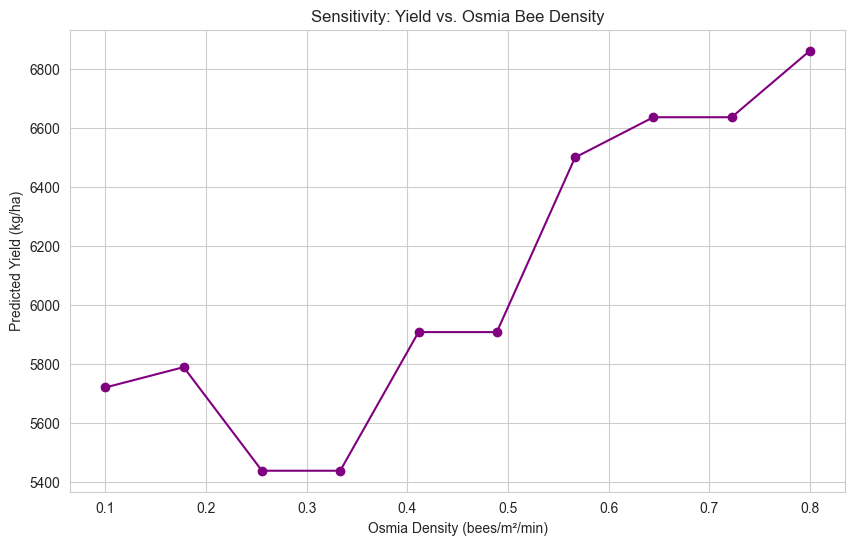

In [53]:
new_data = pd.DataFrame({
    'clonesize': [25], 
    'honeybee': [0.5], 
    'bumbles': [0.38], 
    'andrena': [0.5], 
    'osmia': [0.63], 
    'MaxOfUpperTRange': [86], 
    'RainingDays': [16]
})
predicted_yield = best_model.predict(new_data)
print(f"\nPredicted Yield for Example Data: {predicted_yield[0]:.2f} kg/ha")


osmia_values = np.linspace(0.1, 0.8, 10)
yields = []
for osmia in osmia_values:
    temp_data = new_data.copy()
    temp_data['osmia'] = osmia
    yields.append(best_model.predict(temp_data)[0])

plt.figure()
plt.plot(osmia_values, yields, marker='o', color='purple')
plt.title('Sensitivity: Yield vs. Osmia Bee Density')
plt.xlabel('Osmia Density (bees/m²/min)')
plt.ylabel('Predicted Yield (kg/ha)')
plt.show()

# 9. Cross-Validation for All Models

In [54]:
from sklearn.model_selection import cross_val_score, KFold

models = {
    'MLR': LinearRegression(),
    'AdaBoost': ada_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'XGBoost': xgb_grid.best_estimator_
}

cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    if name == 'MLR':  # Scale for MLR
        cv_scores = -cross_val_score(model, scaler.fit_transform(X), y, cv=kf, scoring='neg_root_mean_squared_error')
    else:
        cv_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    cv_results[name] = {'Mean RMSE': cv_scores.mean(), 'Std RMSE': cv_scores.std()}
    print(f"{name} CV RMSE: {cv_scores.mean():.3f} ± {cv_scores.std():.3f} kg/ha")

# DataFrame for comparison
cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results:\n", cv_df)

MLR CV RMSE: 618.555 ± 37.170 kg/ha
AdaBoost CV RMSE: 554.361 ± 38.575 kg/ha
Random Forest CV RMSE: 354.005 ± 80.013 kg/ha
XGBoost CV RMSE: 286.761 ± 75.150 kg/ha

Cross-Validation Results:
                 Mean RMSE   Std RMSE
MLR            618.554807  37.169564
AdaBoost       554.361214  38.574855
Random Forest  354.005151  80.013143
XGBoost        286.760878  75.150358


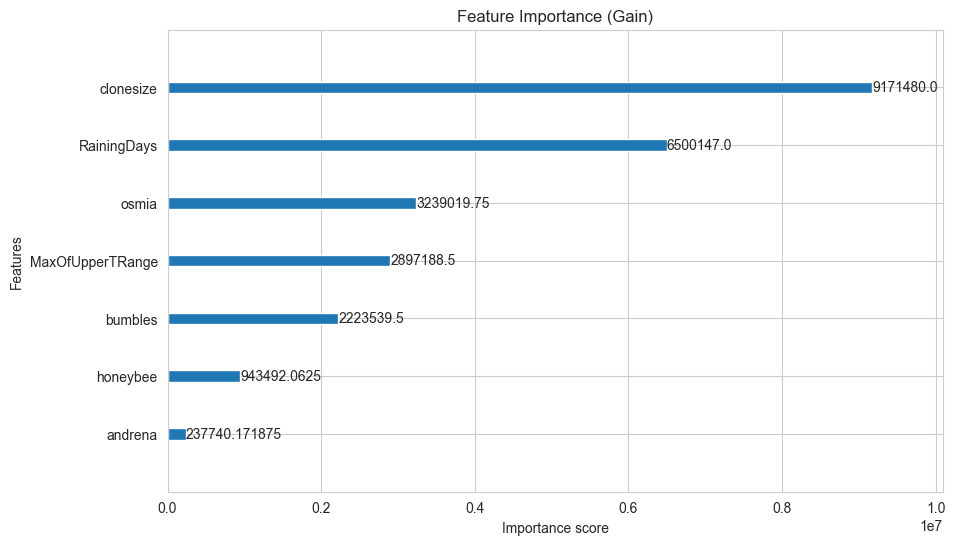

In [55]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()


# 10. Residual Analysis for XGBoost

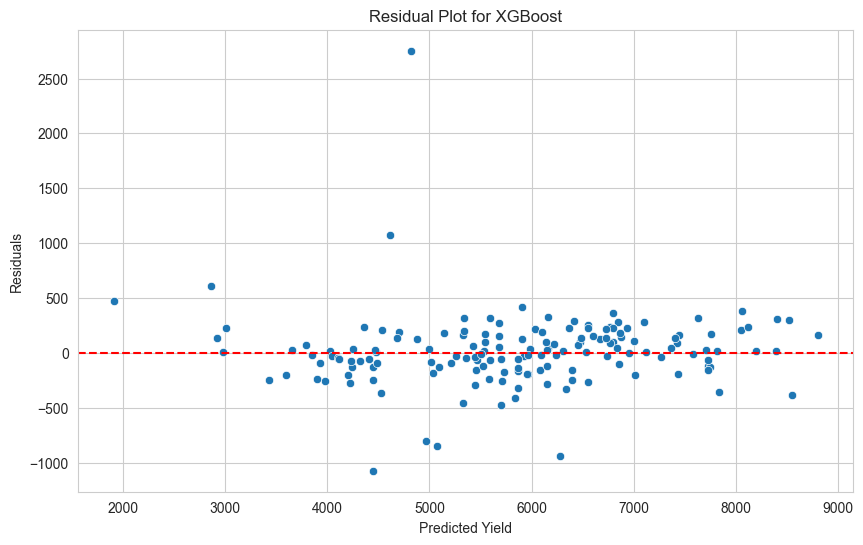

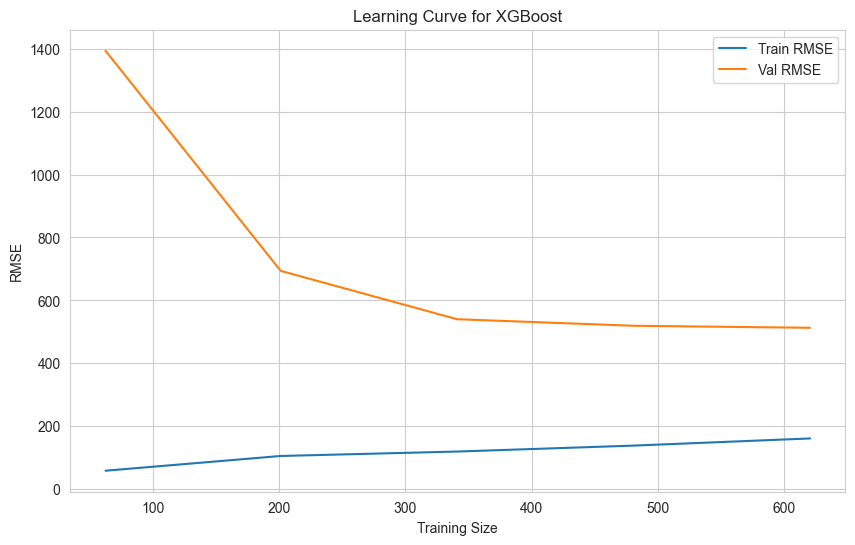

In [ ]:
residuals = y_test - xgb_pred
plt.figure()
sns.scatterplot(x=xgb_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for XGBoost')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.show()

# Learning curve for XGBoost
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(best_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), label='Train RMSE')
plt.plot(train_sizes, -val_scores.mean(1), label='Val RMSE')
plt.title('Learning Curve for XGBoost')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.legend()
plt.show()